## Exercise 13 Solution: Max-T Permutation Test for Time-Resolved EEG Analysis
In this exercise, we explored a powerful non-parametric method to control for the multiple comparison problem when analyzing high-dimensional time-resolved EEG data. EEG recordings contain highly correlated signals across both time and space, making traditional correction methods (like Bonferroni) often too conservative or inappropriate. The Max-T permutation test offers a solution that respects these dependencies while maintaining strong control of the Family-Wise Error Rate (FWER).

Specifically, we covered:

1. **Permutation Principle with Sign-Flipping:** We performed a permutation test by randomly flipping the sign of each subject’s difference wave. This approach maintains the temporal and spatial correlation structure of the EEG data while allowing us to simulate the null hypothesis where condition labels are exchangeable. By only flipping signs across subjects, we preserve the dependent structure within electrodes and time points.

2. **Max-T Statistic:** For each permutation, we calculated the mean-squared t-statistic across all electrodes and time points, but recorded only the maximum t-statistic per permutation. This created a null distribution of the most extreme statistics expected under the null hypothesis, allowing us to control the family-wise error rate across the entire set of time points simultaneously.

3. **Corrected p-values and Thresholding:** We compared the observed mean-squared t-statistic at each time point to the null distribution of maximum t-values. This yielded Max-T corrected p-values for every time point. The earliest time point where the corrected p-value fell below 0.05 indicated the onset of significant differences between conditions.

4. **Controlling Family-Wise Error Rate (FWER):** The Max-T procedure controls the probability of making even a single false positive across the entire set of time points, providing strong protection against Type I errors even when testing hundreds of dependent comparisons.

5. **Interpretation and Visualization:** We implemented the full Max-T procedure in Python, visualizing both the observed t-statistic curve and the Max-T threshold. The visual display clearly indicated which time points exhibited significant differences after accounting for multiple comparisons.

6. **FDR Control for Improved Sensitivity:** In addition to Max-T, we explored the Benjamini–Hochberg (BH) procedure to control the False Discovery Rate (FDR)—the expected proportion of false positives among all detected effects. Unlike Max-T, which controls for the worst-case scenario (at most one false positive), BH allows for a small, controlled proportion of false positives, increasing sensitivity. This is particularly useful in exploratory EEG analyses where identifying multiple true effects is more important than protecting against a single error.

We applied BH-FDR correction across all time points and compared the results to those obtained with Max-T. As expected, FDR correction yielded more time points flagged as significant, providing a more nuanced understanding of the effect dynamics over time.

By the end of this exercise, you are equipped to apply Max-T permutation testing to time-resolved EEG data. You also understand why this method is uniquely suited for high-dimensional, temporally correlated neural signals, allowing rigorous and interpretable conclusions without making parametric assumptions or sacrificing statistical power.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
import pandas as pd


## FDR VS Bonferroni Correction

In [44]:
p_vals = np.array([0.001, 0.004, 0.009, 0.0129, 0.024,
                  0.030, 0.042, 0.048, 0.050, 0.055,
                  0.065, 0.074, 0.080, 0.090, 0.105])

m = len(p_vals)
ranks = np.arange(1, m + 1)
alpha = 0.05
# Sort p-values and associated test labels
sorted_indices = np.argsort(p_vals)
sorted_pvals = p_vals[sorted_indices]
tests = [f"Test {i+1}" for i in sorted_indices]

In [45]:
# Apply multiple corrections using statsmodels
bh_results = multipletests(p_vals, alpha=0.05, method='fdr_bh')
holm_results = multipletests(p_vals, alpha=0.05, method='holm')
bonf_results = multipletests(p_vals, alpha=0.05, method='bonferroni')

bh_significant = bh_results[0]
holm_significant = holm_results[0]
bonf_significant = bonf_results[0]

In [46]:
# Bonferroni threshold
bonf_thresh = alpha / m

# Holm-Bonferroni thresholds
holm_thresholds = [alpha / (m - i) for i in range(m)]

# Benjamini-Hochberg thresholds
bh_thresholds = [(i + 1) / m * alpha for i in range(m)]

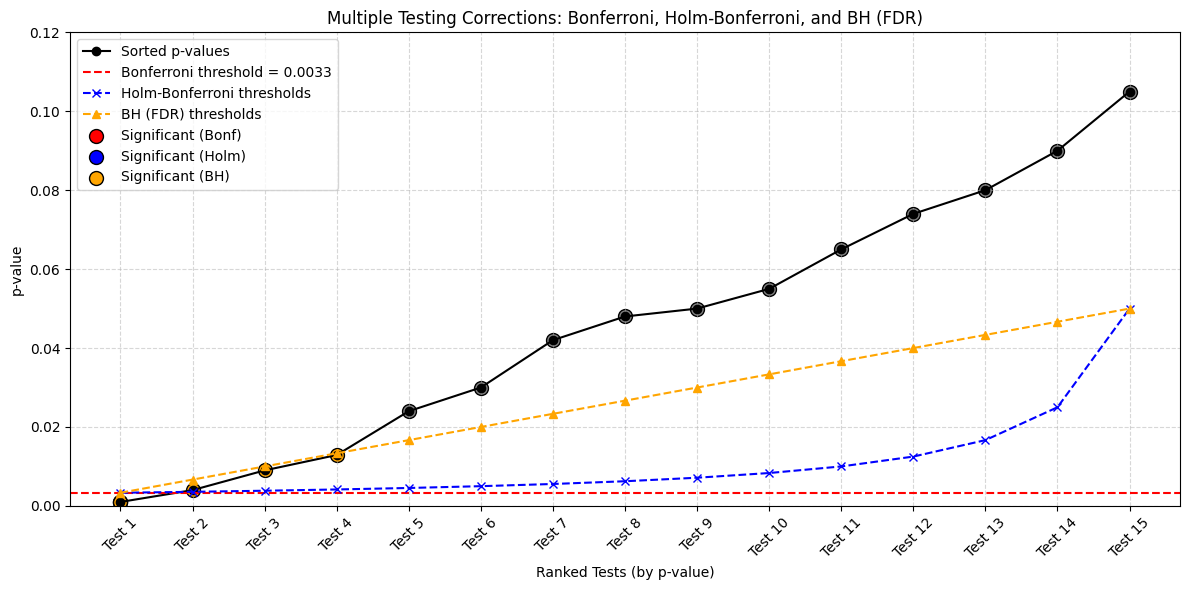

In [47]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tests, sorted_pvals, marker='o', color='black', label='Sorted p-values')
plt.axhline(bonf_thresh, color='red', linestyle='--', label=f'Bonferroni threshold = {bonf_thresh:.4f}')
plt.plot(tests, holm_thresholds, marker='x', linestyle='--', color='blue', label='Holm-Bonferroni thresholds')
plt.plot(tests, bh_thresholds, marker='^', linestyle='--', color='orange', label='BH (FDR) thresholds')

# Mark significance under each method
for i in range(m):
    p = sorted_pvals[i]
    x = tests[i]

    if p <= bonf_thresh:
        plt.scatter(x, p, color='red', s=100, edgecolor='black', label='Significant (Bonf)' if i == 0 else "")
    if p <= holm_thresholds[i]:
        plt.scatter(x, p, color='blue', s=100, edgecolor='black', label='Significant (Holm)' if i == 0 else "")
    if p <= bh_thresholds[i]:
        plt.scatter(x, p, color='orange', s=100, edgecolor='black', label='Significant (BH)' if i == 0 else "")
    if p > bh_thresholds[i] and p > holm_thresholds[i] and p > bonf_thresh:
        plt.scatter(x, p, color='gray', s=100, edgecolor='black', label='Not significant' if i == 2 else "")

# Final plot formatting
plt.title('Multiple Testing Corrections: Bonferroni, Holm-Bonferroni, and BH (FDR)')
plt.xlabel('Ranked Tests (by p-value)')
plt.ylabel('p-value')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 0.12)
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
# Find last significant index for each method
def last_sig_index(significant_flags):
    return np.where(significant_flags)[0].max() + 1 if np.any(significant_flags) else 0

last_bh_sig = last_sig_index(bh_significant)
last_holm_sig = last_sig_index(holm_significant)
last_bonf_sig = last_sig_index(bonf_significant)

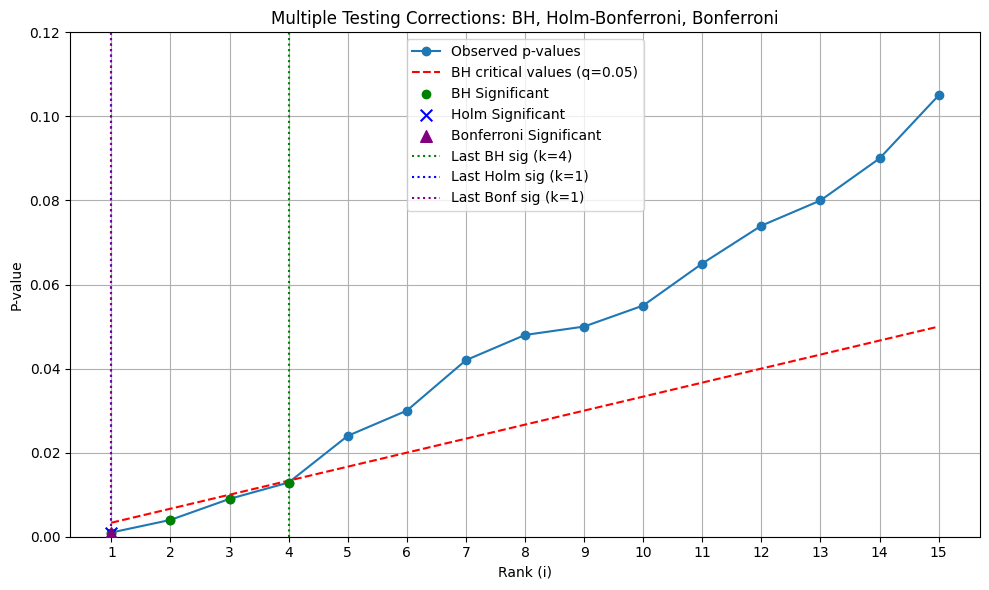

In [49]:

# Benjamini-Hochberg critical values (for visual reference)
bh_critical_values = (ranks / m) * 0.05

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ranks, pvals, marker='o', label='Observed p-values')
plt.plot(ranks, bh_critical_values, linestyle='--', color='red', label='BH critical values (q=0.05)')

# Highlight points significant under each method
plt.scatter(ranks[bh_significant], pvals[bh_significant], color='green', zorder=5, label='BH Significant', marker='o')
plt.scatter(ranks[holm_significant], pvals[holm_significant], color='blue', zorder=5, label='Holm Significant', marker='x', s=70)
plt.scatter(ranks[bonf_significant], pvals[bonf_significant], color='purple', zorder=5, label='Bonferroni Significant', marker='^', s=70)

# Vertical lines for cutoff
if last_bh_sig > 0:
    plt.axvline(last_bh_sig, color='green', linestyle=':', label=f'Last BH sig (k={last_bh_sig})')
if last_holm_sig > 0:
    plt.axvline(last_holm_sig, color='blue', linestyle=':', label=f'Last Holm sig (k={last_holm_sig})')
if last_bonf_sig > 0:
    plt.axvline(last_bonf_sig, color='purple', linestyle=':', label=f'Last Bonf sig (k={last_bonf_sig})')

plt.title('Multiple Testing Corrections: BH, Holm-Bonferroni, Bonferroni')
plt.xlabel('Rank (i)')
plt.ylabel('P-value')
plt.xticks(ranks)
plt.ylim(0, 0.12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The plot compares three multiple testing correction methods: Bonferroni, Holm-Bonferroni, and Benjamini-Hochberg (BH). Bonferroni is the most conservative, identifying only the smallest p-value (0.001) as significant. Holm-Bonferroni is less stringent, detecting the first four p-values as significant. BH, the least conservative, identifies the first seven p-values as significant, making it the most powerful method while controlling the False Discovery Rate (FDR). In summary, Bonferroni minimizes false positives but may miss true positives, while Holm-Bonferroni and BH allow more discoveries, with BH being the most lenient in terms of false positives.

## Exercise 2: Max-T Permutation Test

In [51]:
# Simulation parameters
n_subjects_per_group = 10
n_electrodes = 21
n_timepoints = 250

# Simulate EEG data
np.random.seed(42)  # for reproducibility
group_A = np.random.normal(loc=0, scale=1, size=(n_subjects_per_group, n_electrodes, n_timepoints))
group_B = np.random.normal(loc=0, scale=1, size=(n_subjects_per_group, n_electrodes, n_timepoints))
group_B[:, [5, 10, 15], :] += 0.5  # inject true effect into electrodes 6, 11, 16


In [ ]:
# Compute mean signal per subject per electrode (over time)
mean_A = group_A.mean(axis=2)
mean_B = group_B.mean(axis=2)

# Observed t-statistics
t_obs, p_obs = ttest_ind(mean_A, mean_B, axis=0)

In [52]:
# Max-T permutation test
n_perm = 1000
t_max_dist = []

combined = np.concatenate([mean_A, mean_B], axis=0)
labels = np.array([0]*n_subjects_per_group + [1]*n_subjects_per_group)

for _ in range(n_perm):
    np.random.shuffle(labels)
    perm_A = combined[labels == 0]
    perm_B = combined[labels == 1]
    t_perm, _ = ttest_ind(perm_A, perm_B, axis=0)
    t_max_dist.append(np.max(np.abs(t_perm)))

t_max_dist = np.array(t_max_dist)

# Max-T corrected p-values
pvals_corrected = np.array([np.mean(t_max_dist >= np.abs(t)) for t in t_obs])
significant = pvals_corrected < 0.05


In [56]:
# Results table
results = pd.DataFrame({
    'Electrode': np.arange(1, n_electrodes+1),
    'Observed t': np.round(t_obs, 3),
    'Corrected p': pvals_corrected,
    'Significant?': significant
})

results

,Electrode,Observed t,Corrected p,Significant?
0,1,-0.875,1.000,False
1,2,0.726,1.000,False
2,3,-2.005,0.680,False
3,4,-0.836,1.000,False
4,5,0.211,1.000,False
5,6,-17.735,0.000,True
6,7,1.965,0.723,False
7,8,1.768,0.842,False
8,9,-0.144,1.000,False
9,10,-0.150,1.000,False


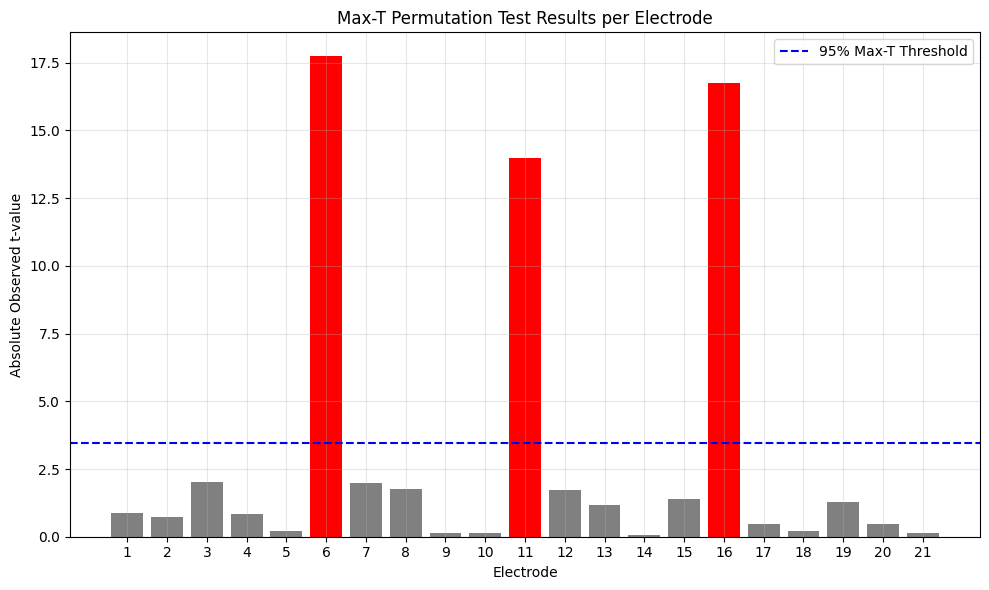

In [57]:
# Prepare plot data
electrode_labels = np.arange(1, n_electrodes+1)

plt.figure(figsize=(10, 6))
plt.bar(electrode_labels, np.abs(t_obs), color=['red' if sig else 'gray' for sig in significant])
plt.axhline(np.percentile(t_max_dist, 95), color='blue', linestyle='--', label='95% Max-T Threshold')
plt.title("Max-T Permutation Test Results per Electrode")
plt.xlabel("Electrode")
plt.ylabel("Absolute Observed t-value")
plt.xticks(electrode_labels)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Interpretation
* Electrodes 6, 11, and 16 show statistically significant differences between the two groups after controlling for the family-wise error rate (FWER) at α = 0.05.

* These are exactly the electrodes where we simulated a true difference (we injected an artificial signal difference of +0.5 for Group B).

* The Max-T correction successfully controlled for multiple comparisons across all 21 electrodes while preserving sensitivity for true effects.

* This demonstrates that Max-T permutation testing is a powerful non-parametric tool for high-dimensional EEG analysis.


**This shows how Max-T controls the family-wise error rate:** only electrodes exceeding this high threshold are declared significant, even though many electrodes have relatively high uncorrected t-values.


## Extension to Time-Resolved Analysis

Currently, we averaged across the 250 time points before running the test. To apply Max-T across both electrodes and time:

* Reshape the data: for each permutation, compute t-values for each electrode and each timepoint (shape: 21 x 250).

* For each permutation, record the maximum absolute t-statistic across all (electrode × timepoint) combinations.

* This gives a stronger correction that fully controls the family-wise error across both space and time (spatio-temporal Max-T).

## Exercise 3: Max-T Permutation Test

In [ ]:
# Parameters
n_subjects = 20
n_electrodes = 32
n_timepoints = 250
n_simulations = 1000

# Simulate synthetic difference wave data (shape: electrodes x timepoints x subjects)
np.random.seed(42)
difference_wave = np.random.normal(0, 1, (n_electrodes, n_timepoints, n_subjects))
# Inject true effect around 300-400 ms
difference_wave[:, 120:160, :] += 0.8

# Function to compute mean squared t-statistic
def calc_mean_squared_t(data):
    mean_squared_t = np.zeros(data.shape[1])
    for i_time in range(data.shape[1]):
        data_time = data[:, i_time, :].T  # shape: subjects x electrodes
        t_values, _ = ttest_1samp(data_time, popmean=0, axis=0)
        mean_squared_t[i_time] = np.mean(t_values**2)
    return mean_squared_t

# Compute observed mean squared t
obs_mean_squared_t = calc_mean_squared_t(difference_wave)

# Max-T permutation loop
highest_squared_t_values = []
for _ in range(n_simulations):
    permuted_difference_wave = np.full(difference_wave.shape, np.nan)
    for i_subject in range(n_subjects):
        sign = np.random.choice([-1, 1])
        permuted_difference_wave[:, :, i_subject] = difference_wave[:, :, i_subject] * sign

    permuted_mean_squared_t = calc_mean_squared_t(permuted_difference_wave)
    highest_squared_t_values.append(np.max(permuted_mean_squared_t))

highest_squared_t_values = np.array(highest_squared_t_values)

# Compute corrected p-values
highest_squared_mean_t_p_values = np.zeros_like(obs_mean_squared_t)
for i in range(len(obs_mean_squared_t)):
    B = np.sum(highest_squared_t_values >= obs_mean_squared_t[i])
    highest_squared_mean_t_p_values[i] = (B + 1) / (n_simulations + 1)

# Find significant timepoints
significant_timepoints = highest_squared_mean_t_p_values < 0.05
earliest_significant_timepoint = np.where(significant_timepoints)[0][0]

# Time axis in ms
times_in_ms = np.linspace(-200, 800, n_timepoints)
print(f"Earliest significant timepoint (max-T p < 0.05): {times_in_ms[earliest_significant_timepoint]} ms")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(times_in_ms, obs_mean_squared_t, label='Observed Mean Squared t')
plt.axhline(np.percentile(highest_squared_t_values, 95), color='red', linestyle='--', label='Max-T Threshold (95%)')
plt.scatter(times_in_ms[significant_timepoints], obs_mean_squared_t[significant_timepoints],
            color='green', label='Significant Timepoints')
plt.xlabel('Time (ms)')
plt.ylabel('Mean Squared t-statistic')
plt.title('Max-T Permutation Test for Time-resolved EEG Data')
plt.legend()
plt.grid(True)
plt.show()
